# Capter 4: Results (part 1)

This chapter presents the main findings, highlighting the most important research results.


In [1]:
import torch
import glob
from torch.utils.data import DataLoader
import numpy as np

from configs import _models
from configs._scanners import get_miniPET_geometry

from generators.mixed import MixedDataset
from utils.data import create_SLPhantom, load_miniPET_sino, load_miniPET_img
from utils.evaluate import evaluate_model
from utils.metrics import compute_metrics
from utils.inits import init_pytorch
from utils.plots import plot_images


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: /opt/conda/envs/smn/lib/libparallelproj_c.so.1.10.0
        parallelproj CUDA lib         ..: /opt/conda/envs/smn/lib/libparallelproj_cuda.so.1.10.0
        parallelproj CUDA kernel file ..: /opt/conda/envs/smn/lib/projector_kernels.cu.1.10.0
        parallelproj CUDA present     ..: True
        parallelproj cupy enabled     ..: True
        


Initialise modules and variables


In [2]:
# Initialize the device
device: torch.device = init_pytorch()

# Set volume dimensions
IMG_WIDTH: int = 147
IMG_HEIGHT: int = 147
IMG_DEPTH: int = 35

Using CUDA with 1 GPU(s)...


In [3]:
# Set the noise level
NOISE_LEVEL: float = 0.5

In [4]:
# Create the miniPET geometry
miniPET_geometry = get_miniPET_geometry(
    device=device, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_rings=IMG_DEPTH
)

In [5]:
BATCH_SIZE: int = 6
TRAIN_SAMPLES: int = 500

In [6]:
synthetic_dataset = MixedDataset(
    device,
    projector=miniPET_geometry.proj,
    n_imgs=TRAIN_SAMPLES,
    n_labels=6,
    noise_interval=(0.1, 1.2),
    kernel_size=5,
    sigma=2.0,
    modality="shapes",
)

data_loader = DataLoader(synthetic_dataset, batch_size=1, shuffle=True)

# Get the first batch of the data loader
data_loader_iter = iter(data_loader)
sinogram_shapes, image_shapes, label_shapes, map_shapes = next(data_loader_iter)

In [7]:
sinogram_slp, image_slp = create_SLPhantom(
    device, IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, miniPET_geometry.proj, NOISE_LEVEL
)

In [8]:
FILE_SINO_PATH: str = "data/sino40min.sino.mnc"
FILE_IMG_PATH: str = "data/GT.mnc"
sinogram_mouse = load_miniPET_sino(device, FILE_SINO_PATH)
image_mouse = load_miniPET_img(device, FILE_IMG_PATH)

In [9]:
NUM_LPD_ITERATIONS: int = 3
SLICE_TO_PLOT: int = 17

shapes_slice: torch.Tensor = image_shapes.squeeze()[:, SLICE_TO_PLOT, :]

slp_slice: torch.Tensor = image_slp[:, SLICE_TO_PLOT, :]
mouse_slice: torch.Tensor = image_mouse[:, SLICE_TO_PLOT, :]

In [10]:
# Initialise the full model
model = _models.get_LPD_Unet2D_model(
    device,
    projector=miniPET_geometry.proj,
    n_iter=NUM_LPD_ITERATIONS,
)

# Move the model to the device
model = model.to(device)

## Mixed Loss Function

The effectiveness of the chosen loss function was tested against two commonly used loss functions in image reconstruction tasks: Mean Squared Error (MSE) and Mean Absolute Error (MAE).


_U-Net LPD MSE_


In [11]:
CONFIG_NAME_1: str = "lpdUnet2D_1"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_1}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    model.load_state_dict(torch.load(file_name, weights_only=True))

    Unet_MSE_shapes = evaluate_model(
        device,
        model,
        sinogram_shapes,
    )

    Unet_MSE_shapes_slice: torch.Tensor = Unet_MSE_shapes[:, SLICE_TO_PLOT, :]

    Unet_MSE_logan = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    ).squeeze()

    Unet_MSE_logan_slice: torch.Tensor = Unet_MSE_logan[:, SLICE_TO_PLOT, :]

    Unet_MSE_mouse = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    Unet_MSE_mouse_slice: torch.Tensor = Unet_MSE_mouse[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet_MSE_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"\nLoss MSE:\tMSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.6262 seconds
Execution time: 0.0887 seconds
Execution time: 0.0904 seconds
Execution time: 0.0854 seconds
Execution time: 0.0915 seconds
Execution time: 0.0900 seconds
Execution time: 0.0852 seconds
Execution time: 0.0897 seconds
Execution time: 0.0910 seconds

Loss MSE:	MSE=8.73e-03 +/- 5.36e-04	SSIM=0.90 +/- 8.88e-03	PSNR=20.60 +/- 2.72e-01


_U-Net LPD MAE_


In [12]:
CONFIG_NAME_2: str = "lpdUnet2D_2"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_2}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    model.load_state_dict(torch.load(file_name, weights_only=True))

    Unet_MAE_shapes = evaluate_model(
        device,
        model,
        sinogram_shapes,
    )

    Unet_MAE_shapes_slice: torch.Tensor = Unet_MAE_shapes[:, SLICE_TO_PLOT, :]

    Unet_MAE_logan = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    ).squeeze()

    Unet_MAE_logan_slice: torch.Tensor = Unet_MAE_logan[:, SLICE_TO_PLOT, :]

    Unet_MAE_mouse = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    Unet_MAE_mouse_slice: torch.Tensor = Unet_MAE_mouse[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet_MAE_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"\nLoss MAE:\tMSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.0848 seconds
Execution time: 0.0903 seconds
Execution time: 0.0904 seconds
Execution time: 0.0853 seconds
Execution time: 0.0902 seconds
Execution time: 0.0902 seconds
Execution time: 0.0858 seconds
Execution time: 0.0904 seconds
Execution time: 0.0913 seconds

Loss MAE:	MSE=1.05e-02 +/- 2.24e-04	SSIM=0.87 +/- 2.03e-02	PSNR=19.78 +/- 9.29e-02


_U-Net LPD MSE+DICE_


In [13]:
CONFIG_NAME_3: str = "lpdUnet2D_3"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_3}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    model.load_state_dict(torch.load(file_name, weights_only=True))

    Unet_DICE_shapes = evaluate_model(
        device,
        model,
        sinogram_shapes,
    )

    Unet_DICE_shapes_slice: torch.Tensor = Unet_DICE_shapes[:, SLICE_TO_PLOT, :]

    Unet_DICE_logan = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    ).squeeze()

    Unet_DICE_logan_slice: torch.Tensor = Unet_DICE_logan[:, SLICE_TO_PLOT, :]

    Unet_DICE_mouse = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    Unet_DICE_mouse_slice: torch.Tensor = Unet_DICE_mouse[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet_DICE_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"\nLoss MSE+Dice:\tMSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.0850 seconds
Execution time: 0.0904 seconds
Execution time: 0.0908 seconds
Execution time: 0.0857 seconds
Execution time: 0.0920 seconds
Execution time: 0.0892 seconds
Execution time: 0.0860 seconds
Execution time: 0.0906 seconds
Execution time: 0.0904 seconds

Loss MSE+Dice:	MSE=8.44e-03 +/- 2.04e-04	SSIM=0.91 +/- 3.22e-03	PSNR=20.74 +/- 1.05e-01


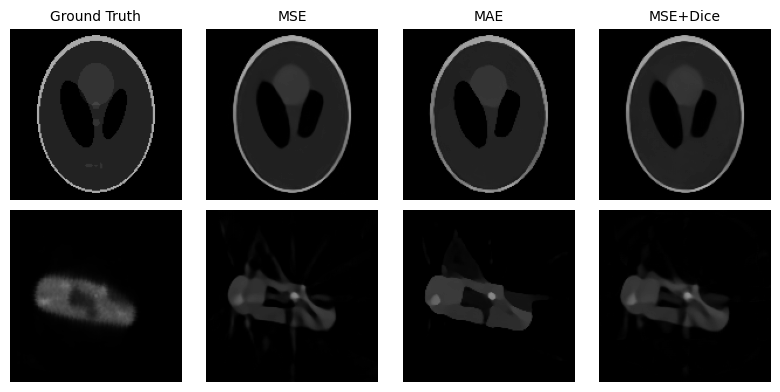

In [14]:
plot_images(
    [
        (slp_slice.cpu().numpy(), "Ground Truth"),
        (Unet_MSE_logan_slice.cpu().numpy(), "MSE"),
        (Unet_MAE_logan_slice.cpu().numpy(), "MAE"),
        (
            Unet_DICE_logan_slice.cpu().numpy(),
            "MSE+Dice",
        ),
        (mouse_slice.cpu().numpy(), ""),
        (Unet_MSE_mouse_slice.cpu().numpy(), ""),
        (Unet_MAE_mouse_slice.cpu().numpy(), ""),
        (
            Unet_DICE_mouse_slice.cpu().numpy(),
            "",
        ),
    ]
)

### Reconstructed Labels

The reconstructed label maps were generated by assigning each point in the
reconstructed images, the label associated with the closest intensity value.


In [15]:
import torch
import torch.nn.functional as F
from einops import rearrange


def _get_recon_labels(
    device, recon_imgs: torch.Tensor, mappings: torch.Tensor
) -> torch.Tensor:
    """This function reconstructs the labels map from the reconstructed images.

    Args:
        recon_imgs (torch.Tensor): The reconstructed images (batch of 3D images).
        mappings (torch.Tensor): The mapping between the image values and the original
            labels (batch of 1D mappings).

    Returns:
        torch.Tensor: The reconstructed label maps.
    """
    # Expand values tensor to match the shape of entries for broadcasting
    values_expanded = mappings.view(mappings.shape[0], 1, 1, 1, mappings.shape[-1])

    # Compute the absolute differences between entries and values
    differences = torch.abs(recon_imgs.unsqueeze(-1) - values_expanded)

    # Find the indices of the minimum values along the last dimension
    closest_indices = torch.argmin(differences, dim=-1)

    # One-hot encode the indices of the nearest key
    recon_label_maps = F.one_hot(closest_indices, num_classes=mappings.shape[-1]).to(
        device
    )

    # Rearrange the dimensions to match the target label map shape
    recon_label_maps = rearrange(recon_label_maps, "b h w d c -> b c h w d")

    return recon_label_maps

In [16]:
Unet_MSE_labels = _get_recon_labels(device, Unet_MSE_shapes, map_shapes)
Unet_MAE_labels = _get_recon_labels(device, Unet_MAE_shapes, map_shapes)
Unet_DICE_labels = _get_recon_labels(device, Unet_DICE_shapes, map_shapes)

In [17]:
from models.functions.losses import Dice

dice = Dice()

print(f"MSE:\t\tDICE={dice(Unet_MSE_labels, label_shapes):.4f}")
print(f"MAE:\t\tDICE={dice(Unet_MAE_labels, label_shapes):.4f}")
print(f"MSE+Dice:\tDICE={dice(Unet_DICE_labels, label_shapes):.4f}")

MSE:		DICE=0.2640
MAE:		DICE=0.2507
MSE+Dice:	DICE=0.2659


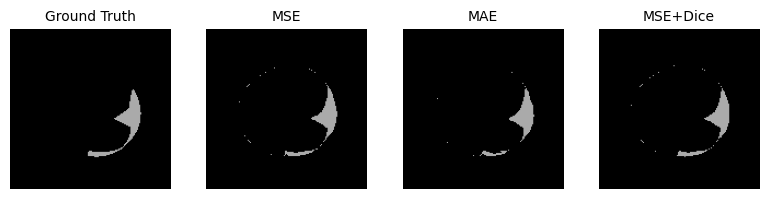

In [18]:
LABEL_TO_PLOT = 1

label_shapes_slice = label_shapes[0, LABEL_TO_PLOT, :, SLICE_TO_PLOT, :]
Unet_MSE_labels_slice = Unet_MSE_labels[0, LABEL_TO_PLOT, :, SLICE_TO_PLOT, :]
Unet_MAE_labels_slice = Unet_MAE_labels[0, LABEL_TO_PLOT, :, SLICE_TO_PLOT, :]
Unet_DICE_labels_slice = Unet_DICE_labels[0, LABEL_TO_PLOT, :, SLICE_TO_PLOT, :]


plot_images(
    [
        (label_shapes_slice.cpu().numpy(), "Ground Truth"),
        (Unet_MSE_labels_slice.cpu().numpy(), "MSE"),
        (Unet_MAE_labels_slice.cpu().numpy(), "MAE"),
        (
            Unet_DICE_labels_slice.cpu().numpy(),
            "MSE+Dice",
        ),
    ]
)

## Synthetic Training Data

The synthetic dataset generator was constructed to generate both random ellipsoids and random shapes.


_U-Net LPD MSE+Dice Ellipsoids only_


In [19]:
CONFIG_NAME_4: str = "lpdUnet2D_4"

WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_4}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    model.load_state_dict(torch.load(file_name, weights_only=True))

    Unet_ELL_shapes = evaluate_model(
        device,
        model,
        sinogram_shapes,
    )

    Unet_ELL_shapes_slice: torch.Tensor = Unet_ELL_shapes[:, SLICE_TO_PLOT, :]

    Unet_ELL_logan = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    ).squeeze()

    Unet_ELL_logan_slice: torch.Tensor = Unet_ELL_logan[:, SLICE_TO_PLOT, :]

    Unet_ELL_mouse = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    Unet_ELL_mouse_slice: torch.Tensor = Unet_ELL_mouse[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet_ELL_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"\nEllipsoids only:\tMSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.0859 seconds
Execution time: 0.0926 seconds
Execution time: 0.0892 seconds
Execution time: 0.0862 seconds
Execution time: 0.0902 seconds
Execution time: 0.0907 seconds
Execution time: 0.0861 seconds
Execution time: 0.0916 seconds
Execution time: 0.0906 seconds

Ellipsoids only:	MSE=7.58e-03 +/- 3.01e-04	SSIM=0.92 +/- 1.59e-03	PSNR=21.21 +/- 1.70e-01


_U-Net LPD MSE+Dice Shapes only_


In [20]:
CONFIG_NAME_5: str = "lpdUnet2D_5"
WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_5}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    model.load_state_dict(torch.load(file_name, weights_only=True))

    Unet_SHA_shapes = evaluate_model(
        device,
        model,
        sinogram_shapes,
    )

    Unet_SHA_shapes_slice: torch.Tensor = Unet_SHA_shapes[:, SLICE_TO_PLOT, :]

    Unet_SHA_logan = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    ).squeeze()

    Unet_SHA_logan_slice: torch.Tensor = Unet_SHA_logan[:, SLICE_TO_PLOT, :]

    Unet_SHA_mouse = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    Unet_SHA_mouse_slice: torch.Tensor = Unet_SHA_mouse[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet_SHA_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"\nShapes only:\tMSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.0859 seconds
Execution time: 0.0904 seconds
Execution time: 0.0910 seconds
Execution time: 0.0856 seconds
Execution time: 0.0904 seconds
Execution time: 0.0904 seconds
Execution time: 0.0866 seconds
Execution time: 0.0906 seconds
Execution time: 0.0911 seconds

Shapes only:	MSE=9.96e-03 +/- 1.28e-04	SSIM=0.90 +/- 1.22e-03	PSNR=20.02 +/- 5.55e-02


_U-Net LPD MSE+Dice Mixed_


In [21]:
CONFIG_NAME_6: str = "lpdUnet2D_3"
WEIGHTS_PATH: str = f"outputs/{CONFIG_NAME_6}/*_weights.pt"

mse_list = []
ssim_list = []
psnr_list = []

for file_name in sorted(glob.glob(WEIGHTS_PATH), reverse=True):
    model.load_state_dict(torch.load(file_name, weights_only=True))

    Unet_MIX_shapes = evaluate_model(
        device,
        model,
        sinogram_shapes,
    )

    Unet_MIX_shapes_slice: torch.Tensor = Unet_MIX_shapes[:, SLICE_TO_PLOT, :]

    Unet_MIX_logan = evaluate_model(
        device,
        model,
        sinogram_slp.unsqueeze(0),
    ).squeeze()

    Unet_MIX_logan_slice: torch.Tensor = Unet_MIX_logan[:, SLICE_TO_PLOT, :]

    Unet_MIX_mouse = evaluate_model(
        device,
        model,
        sinogram_mouse.unsqueeze(0),
    )

    Unet_MIX_mouse_slice: torch.Tensor = Unet_MIX_mouse[:, SLICE_TO_PLOT, :]

    # Compute metrics
    metrics = compute_metrics(device, image_slp, Unet_MIX_logan)
    mse_list.append(metrics["mse"].item())
    ssim_list.append(metrics["ssim"].item())
    psnr_list.append(metrics["psnr"].item())

print(
    f"\nMixed:\tMSE={np.mean(mse_list):.2e} +/- {np.std(mse_list):.2e}\tSSIM={np.mean(ssim_list):.2f} +/- {np.std(ssim_list):.2e}\tPSNR={np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2e}"
)

Execution time: 0.0855 seconds
Execution time: 0.0935 seconds
Execution time: 0.0883 seconds
Execution time: 0.0852 seconds
Execution time: 0.0905 seconds
Execution time: 0.0907 seconds
Execution time: 0.0854 seconds
Execution time: 0.0904 seconds
Execution time: 0.0908 seconds

Mixed:	MSE=8.44e-03 +/- 2.04e-04	SSIM=0.91 +/- 3.22e-03	PSNR=20.74 +/- 1.05e-01


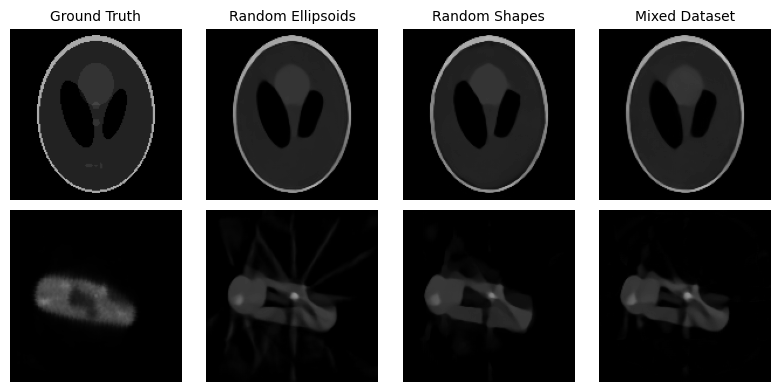

In [22]:
plot_images(
    [
        (slp_slice.cpu().numpy(), "Ground Truth"),
        (Unet_ELL_logan_slice.cpu().numpy(), "Random Ellipsoids"),
        (Unet_SHA_logan_slice.cpu().numpy(), "Random Shapes"),
        (
            Unet_MIX_logan_slice.cpu().numpy(),
            "Mixed Dataset",
        ),
        (mouse_slice.cpu().numpy(), ""),
        (Unet_ELL_mouse_slice.cpu().numpy(), ""),
        (Unet_SHA_mouse_slice.cpu().numpy(), ""),
        (
            Unet_MIX_mouse_slice.cpu().numpy(),
            "",
        ),
    ]
)